# Global adaptive time-stepping for a locally compressed monolayer due to a single proliferation event

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
separation = 0.3 # initial separation between daughter cells

dim = 2

seed=67
npr.seed(seed)

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], 0.0, proliferating=False) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, move cell there and add second daughter cells
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    
    # get division direction
    random_angle = 2.0 * np.pi * npr.rand()
    division_direction = np.array([np.cos(random_angle), np.sin(random_angle)])
    
    # update positions
    updated_position_parent = coords - 0.5 * separation * division_direction
    sheet[m].position = updated_position_parent   

    position_daughter = coords + 0.5 * separation * division_direction    
    
    # add daughter cell
    next_cell_index = len(sheet)
    daughter_cell = cl.Cell(next_cell_index, position_daughter, birthtime=0.0, proliferating=False)
    sheet.append(daughter_cell)
        
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [7]:
# plot function
# eigenvector must contain eigenvector corresponding to a single eigenvalue
def plot_eigenvector_on_population(cell_list, eigenvector, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    eigenvector = eigenvector.reshape((n_cells, -1))
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
        plt.plot([cell_list[i].position[0], cell_list[i].position[0] + eigenvector[i, 0]], [cell_list[i].position[1],cell_list[i].position[1]+eigenvector[i,1]])
    plt.show()

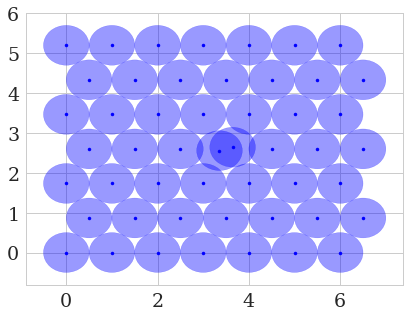

In [8]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

In [9]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


# No Jacobian - accuracy bound only

Initial step cubic 0.04532529420993759
Stability bound estimate cubic 0.7478811326233553
Initial step pw. quad. 0.07615884368444005
Stability bound estimate pw. quad. 0.7015968091532179
Initial step GLS 0.12333068190892811
Stability bound estimate GLS 0.646436138354775


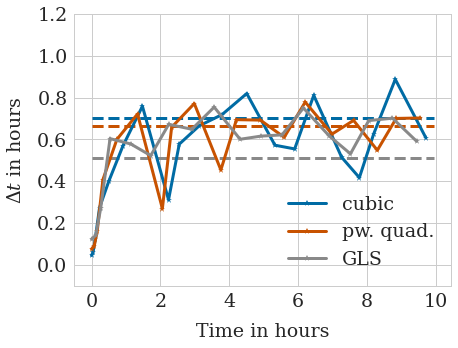

In [12]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

ts = {}

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_local'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('levels'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts[force], history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.05,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True, "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[force][:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_local_compression_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

Text(0, 0.5, 'Number of equations per level')

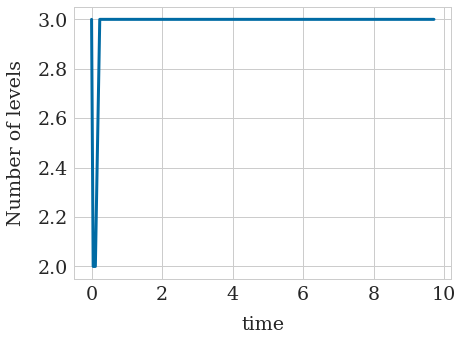

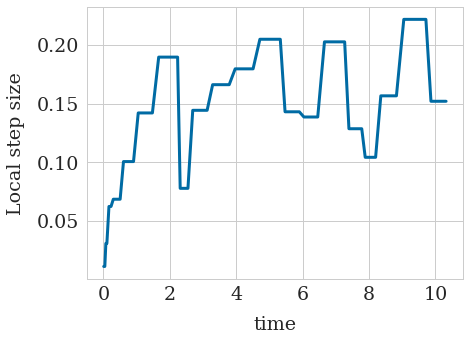

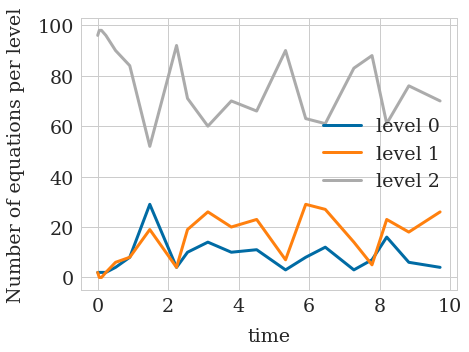

In [13]:
force = 'cubic'
plt.figure()
lev  = np.loadtxt('levels'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local'+filename_ending[force]+'.txt')
plt.plot(np.cumsum(dt_locals), dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[force][:-1], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[force][:-1], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')

Initial step cubic 0.006409964579024445
Stability bound estimate cubic 0.29271994284613767
Initial step pw. quad. 0.010770486963318766
Stability bound estimate pw. quad. 0.40196162570501875
Initial step GLS 0.017441592301232826
Stability bound estimate GLS 0.274176120655547


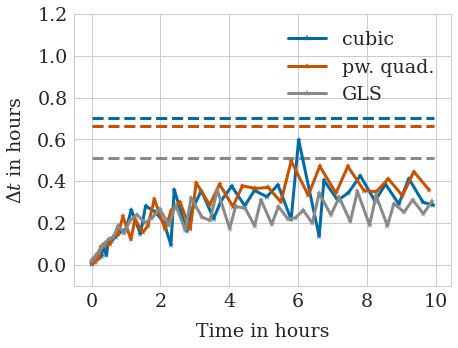

In [14]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

ts={}
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_local'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('levels'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts[force], history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    plt.plot(ts[force][:-1], dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_local_compression_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


Text(0, 0.5, 'Number of equations per level')

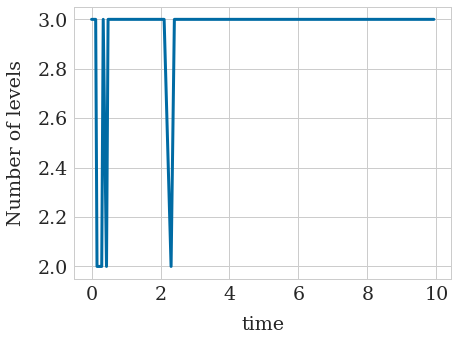

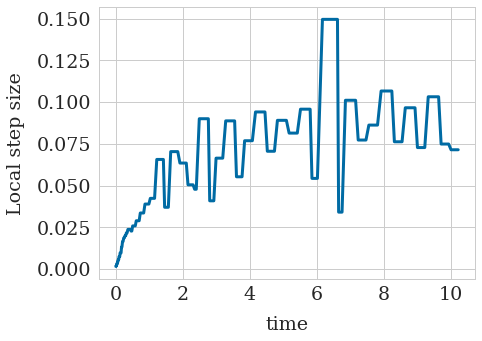

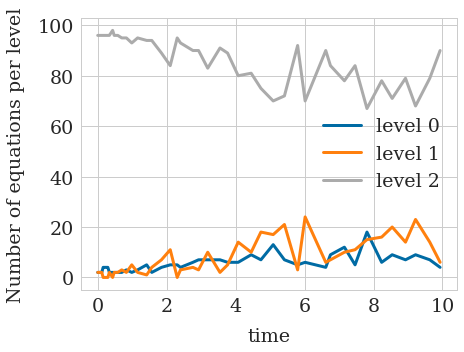

In [15]:
force = 'cubic'
plt.figure()
lev  = np.loadtxt('levels'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local'+filename_ending[force]+'.txt')
plt.plot(np.cumsum(dt_locals), dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[force][:-1], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[force][:-1], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')

In [11]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.Cubic()(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.PiecewisePolynomial()(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS ' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS 0.008095015365876104


# Using the Jacobian to obtain the stability bound

Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.


Text(0, 0.5, '$\\Delta t$ in hours')

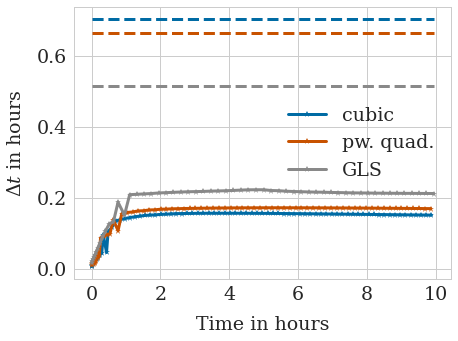

In [17]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

ts={}
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_local'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('levels'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvalues'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvectors'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts[force], history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[force][:-1], dts,'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')


Text(0, 0.5, 'Number of equations per level')

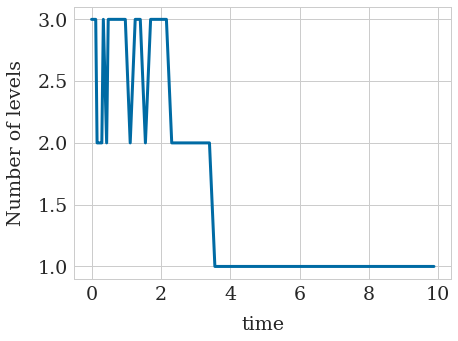

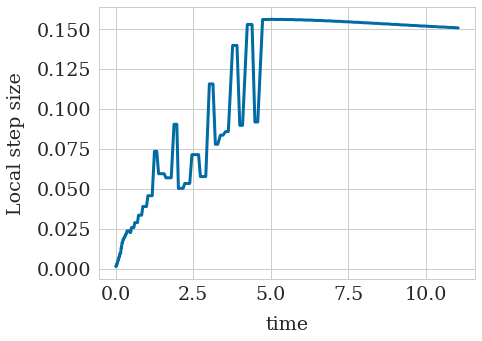

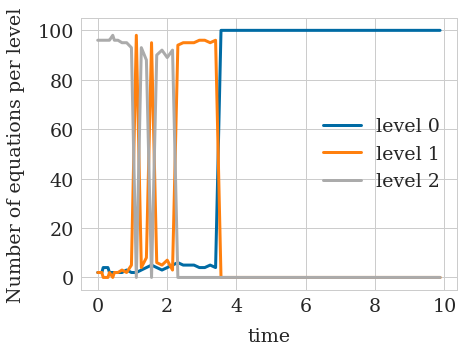

In [18]:
force = 'cubic'
plt.figure()
lev  = np.loadtxt('levels'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local'+filename_ending[force]+'.txt')
plt.plot(np.cumsum(dt_locals), dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[force][:-1], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[force][:-1], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')